#Working with MNE and EEG-BIDS Part 2

In this notebook we will go over:


*   Epochs and evoked responses
*   Cleaning epoched data



#Import packages

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import mne_bids

Ensure Matplotlib uses the `Qt5Agg` backend, which is the best choice for MNE-Python's interactive plotting functions. 

In [ ]:
matplotlib.use('Qt5Agg')

#Load Dataset

We will continue to work on the BIDS version of our sample dataset created in the previous notebook.

In [ ]:
#Set the path to the location of the BIDS data
bids_root = pathlib.Path('out_data/sample_BIDS')
#Set the variables for the BIDS directory
bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='audiovisual',
                              run='01',
                              datatype='meg',
                              root=bids_root)
#Read and load the data
raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
events, event_id = mne.events_from_annotations(raw)

# Creating epochs and generating evoked responses (ERP/ERF)

Evoked objects typically store EEG signals that have been averaged over multiple epochs, which is a common technique for estimating stimulus-evoked activity. Thus, to create an Evoked object, we’ll start by epoching some raw data, and then averaging together all the epochs from one condition.

## Create epochs for the events

In [ ]:
#Epochs will start 300 ms before the stimulus onset and end 
#500 ms after stimulus onset
tmin = -0.3
tmax = 0.5
baseline = (None, 0)

epochs = mne.Epochs(raw,
                    events=events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True)
epochs

Not setting metadata
320 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 320 events and 481 original time points ...
174 bad epochs dropped


Number of events,146
Events,Auditory/Left: 34Auditory/Right: 34Button: 7Smiley: 7Visual/Left: 33Visual/Right: 31
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


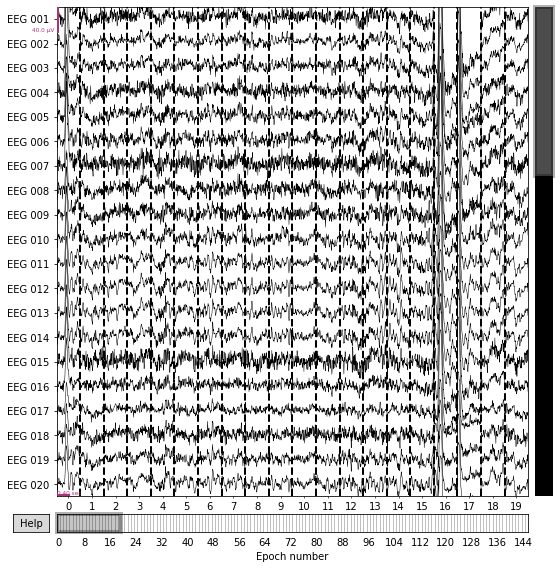

In [ ]:
epochs.plot(picks = ['eeg']);

We can look at epochs based on condition

In [ ]:
epochs['Auditory/Right']

Number of events,34
Events,Auditory/Right: 34
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


In [ ]:
epochs['Auditory']

Number of events,68
Events,Auditory/Left: 34Auditory/Right: 34
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


In [ ]:
epochs['Left']

Number of events,67
Events,Auditory/Left: 34Visual/Left: 33
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


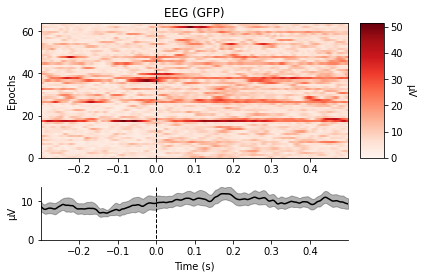

[<Figure size 432x288 with 3 Axes>]

In [ ]:
epochs['Visual'].plot_image(picks = "eeg")

### Saving epochs

In [ ]:
epochs.save(pathlib.Path('out_data') / 'epochs_epo.fif', 
            overwrite=True)

## Creating evoked data

Now we can create evoked responses for each condition

In [ ]:
evoked_auditory = epochs['Auditory'].average()
evoked_visual = epochs['Visual'].average()

##Basic visualization of Evoked objects
We can visualize the average evoked response for the auditory stimuli using the plot() method, which yields a butterfly plot of each channel type. Like many MNE-Python plotting functions, evoked.plot() has a picks parameter that can select channels to plot by name, index, or type. We will specifically look at EEG channels.

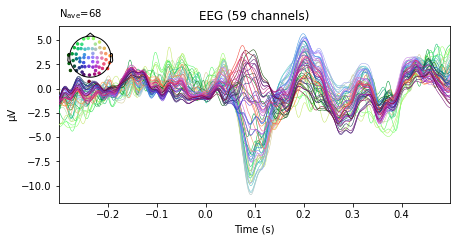

In [ ]:
evoked_auditory.plot(spatial_colors=True, picks = ['eeg']);

In an interactive session, the butterfly plots seen above can be click-dragged to select a time region, which will pop up a map of the average field distribution over the scalp for the selected time span. You can also generate scalp topographies seperately or jointly at specific times or time spans using the plot_topomap() method.

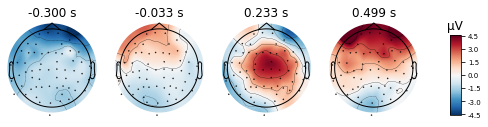

In [ ]:
evoked_auditory.plot_topomap(ch_type='eeg');

Joint plots combine butterfly plots with scalp topographies, and provide an excellent first-look at evoked data; by default, topographies will be automatically placed based on peak finding. 

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


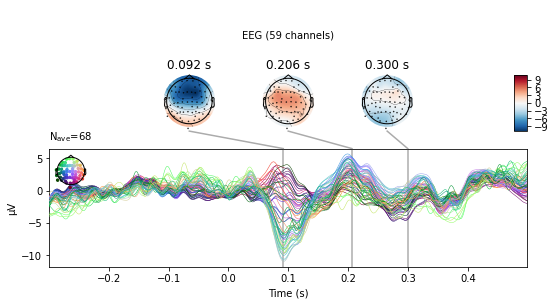

In [ ]:
evoked_auditory.plot_joint(picks='eeg');

Here we compare evoked responses by looking at the global field power (an average-referenced RMS)

combining channels using "gfp"
combining channels using "gfp"


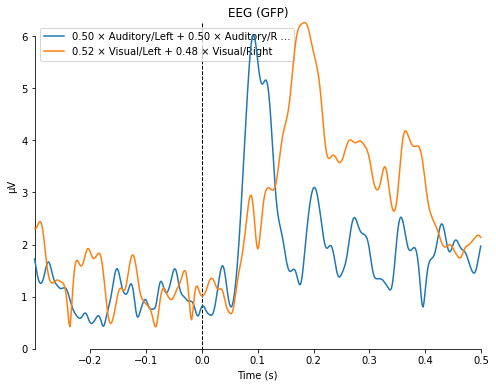

[<Figure size 576x432 with 1 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds([evoked_auditory, evoked_visual], picks='eeg')

## Saving evoked data

In [ ]:
mne.write_evokeds(fname=pathlib.Path('out_data') / 'evokeds_ave.fif',
                  evoked=[evoked_auditory, evoked_visual],overwrite=True)

# Cleaning the Data

Severe contamination of EEG activity by eye movements, blinks, muscle, heart and line noise is a serious problem for EEG interpretation and analysis. One method proposed to remove a wide variety of artifacts from EEG recordings is **Independent Component Analysis (ICA)**.

## ICA Artifact Detection and Removal


Independent components analysis (ICA) is a technique for estimating independent source signals from a set of recordings in which the source signals were mixed together in unknown ratios. 

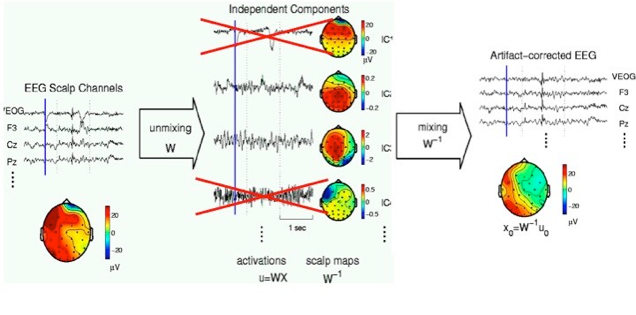


We will apply ICA on our epoched data but this can be done directly on the filtered raw data as well.

In [ ]:
epochs = mne.read_epochs(pathlib.Path('out_data') / 'epochs_epo.fif')

Reading /content/out_data/epochs_epo.fif ...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
    Found the data of interest:
        t =    -299.69 ...     499.49 ms
        0 CTF compensation matrices available
Not setting metadata
146 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
3 projection items activated


In [ ]:
#we will work the eeg channels only
epochs.pick_types(eeg=True)

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


Number of events,146
Events,Auditory/Left: 34Auditory/Right: 34Button: 7Smiley: 7Visual/Left: 33Visual/Right: 31
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


### Fitting and plotting the ICA solution

In [ ]:
n_components = 20
method = 'infomax'
max_iter = 100  # Should normally be higher, like 500 or even 1000!!
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            random_state=random_state)
ica.fit(epochs)

Fitting ICA to data using 58 channels (please be patient, this may take a while)


<ipython-input-81-f3990e247eec>:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 20 components
 
Fitting ICA took 7.0s.


Method,infomax
Fit,100 iterations on epochs (70226 samples)
ICA components,20
Available PCA components,58
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
#note if you need to rerun ICA you need to delete the ica instance saved in memory
#del ica

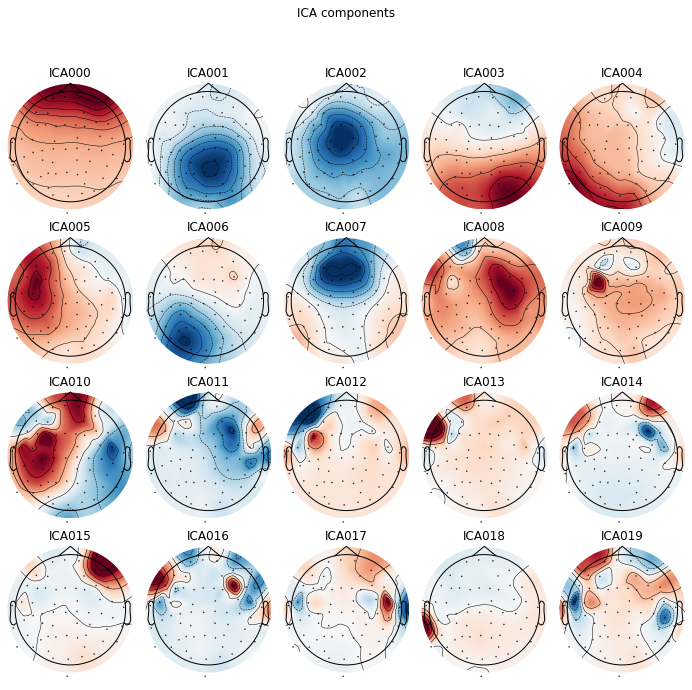

[<MNEFigure size 702x696.24 with 20 Axes>]

In [ ]:
ica.plot_components(inst=epochs)

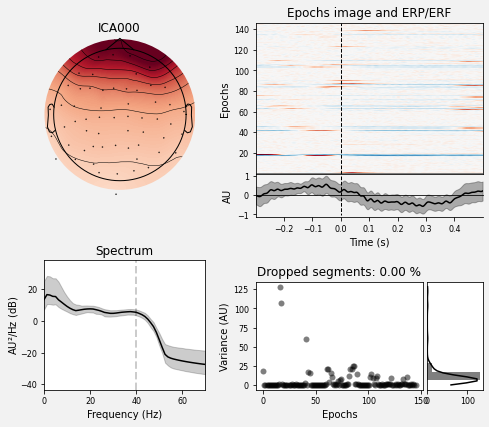

[<Figure size 504x432 with 6 Axes>]

In [ ]:
ica.plot_properties(epochs,picks =[0],psd_args ={'fmax': 70}, verbose='WARNING')

Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


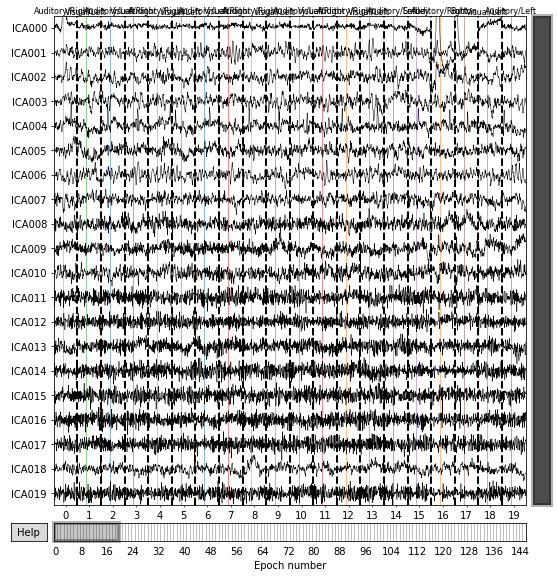

In [ ]:
ica.plot_sources(epochs);

### Selecting ICA Components Manually

For more info on visually identifying Independent Components, this [EEGLAB guide](https://labeling.ucsd.edu/tutorial/labels) is a good resource.

Let's say we decided to remove the first component, we can plot and see what the signal looks like before and after exclusion using an overlay plot.

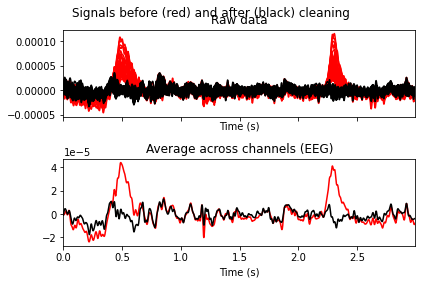

In [ ]:
ica.plot_overlay(raw, exclude=[0], verbose='WARNING');

Now we apply the exclusion

In [ ]:
ica.exclude = [0] 
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_epochs = epochs.copy()
ica.apply(reconst_epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components


<ipython-input-92-006badbb1e95>:4: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(reconst_epochs)


Number of events,146
Events,Auditory/Left: 34Auditory/Right: 34Button: 7Smiley: 7Visual/Left: 33Visual/Right: 31
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


We can plot and compare before and after ICA

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


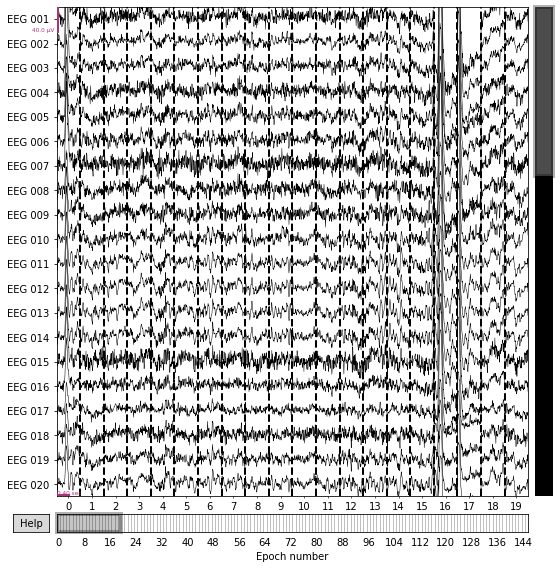

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


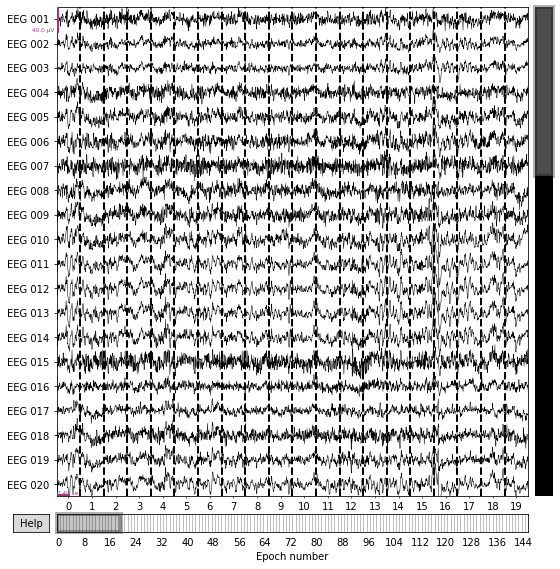

In [ ]:
epochs.plot();
reconst_epochs.plot();

### Automatic: Using an EOG/ECG channel to select ICA components

It may have seemed easy to review the plots and manually select which ICs to exclude, but when processing dozens or hundreds of subjects this can become a tedious, rate-limiting step in the analysis pipeline. One alternative is to use dedicated EOG or ECG sensors as a “pattern” to check the ICs against, and automatically mark for exclusion any ICs that match the EOG/ECG pattern.

We apply this to the raw data

#### EOG

Using EOG channel: EOG 061
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


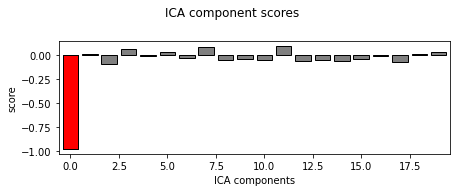

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


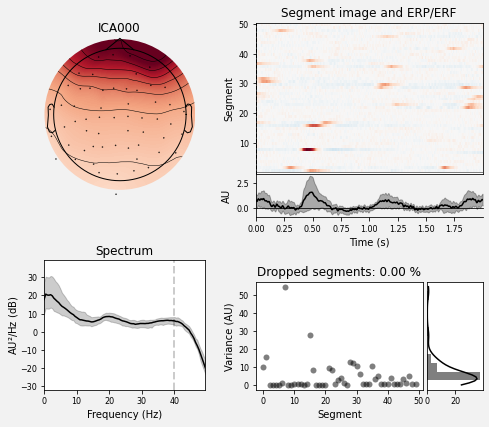

Creating RawArray with float64 data, n_channels=21, n_times=60062
    Range : 25800 ... 85861 =     42.956 ...   142.955 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


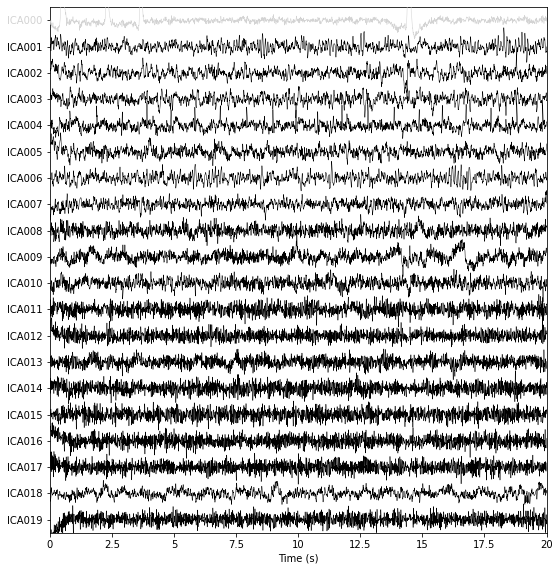

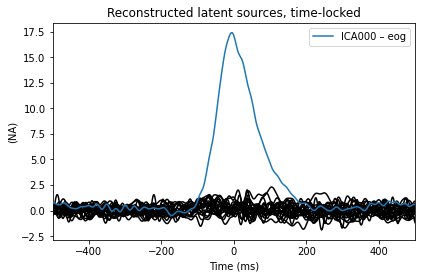

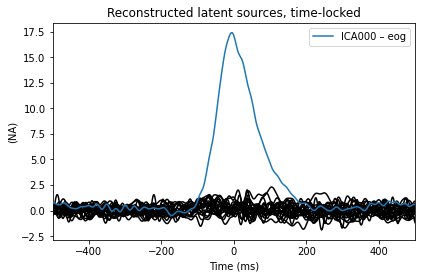

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores);

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices);

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw);

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked);

#### ECG

Reconstructing ECG signal from Magnetometers
Using threshold: 0.21 for CTPS ECG detection
Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Number of ECG events detected : 99 (average pulse 59 / min.)
Not setting metadata
99 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 99 events and 601 original time points ...
0 bad epochs dropped


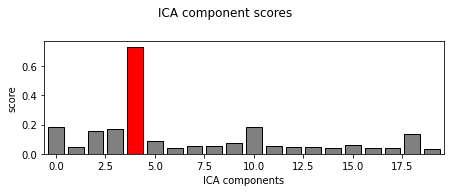

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


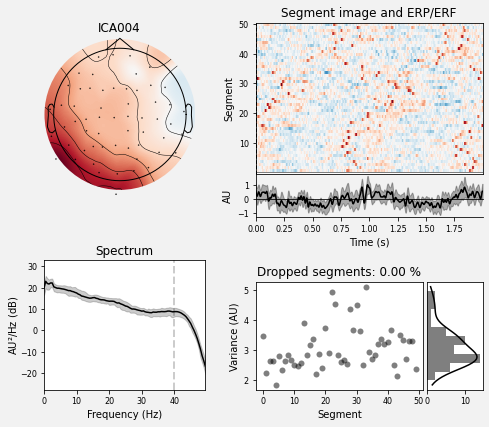

Creating RawArray with float64 data, n_channels=21, n_times=60062
    Range : 25800 ... 85861 =     42.956 ...   142.955 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


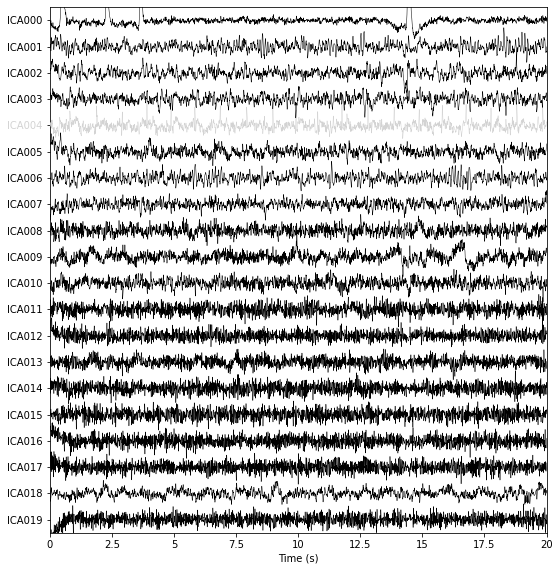

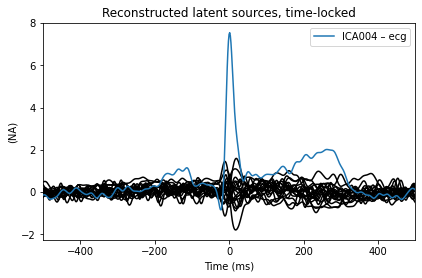

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw)
ica.exclude = ecg_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(ecg_scores)

# plot diagnostics
ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(ecg_evoked);

##Extra: Remove Epochs with Artifacts

Another method for artifact detection is rejecting contaminated EEG epochs, however, this typically results in a considerable loss of collected information.

### Reject artifacts based on channel signal amplitude

In [ ]:
reject_criteria = dict(mag=3000e-15,     # 3000 fT
                       grad=3000e-13,    # 3000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=200e-6)       # 200 µV

flat_criteria = dict(mag=1e-15,          # 1 fT
                     grad=1e-13,         # 1 fT/cm
                     eeg=1e-6)           # 1 µV

In [ ]:
epochs.drop_bad(reject=reject_criteria, flat=flat_criteria)

    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 019', 'EEG 022', 'EEG 023']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 019', 'EEG 022', 'EEG 023']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on MAG : ['MEG 1421']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 010', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016']
    Rejecting  epoch based on MAG : ['MEG 142

Number of events,223
Events,Auditory/Left: 46Auditory/Right: 49Button: 12Smiley: 11Visual/Left: 61Visual/Right: 44
Time range,-0.300 – 0.499 sec
Baseline,-0.300 – 0.000 sec


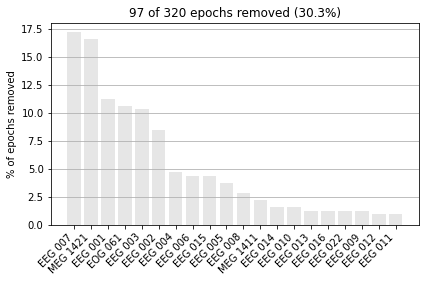

In [ ]:
epochs.plot_drop_log();

Quite a number of Epochs were dropped due to EOG artifacts.

#Refrences

**MNE-Python** - 
Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. doi:10.3389/fnins.2013.00267.
